✅ Preprocessing Summary for TotalClaims Severity Model
Total rows after filtering: 2775
Selected features: ['Province', 'VehicleType', 'RegistrationYear', 'make', 'SumInsured', 'CalculatedPremiumPerTerm']

▶ Feature: Province
Province
Gauteng          1322
KwaZulu-Natal     483
Western Cape      357
North West        349
Mpumalanga        128
Name: count, dtype: int64

▶ Feature: VehicleType
VehicleType
Passenger Vehicle    2587
Medium Commercial     158
Heavy Commercial       21
Light Commercial        8
Bus                     1
Name: count, dtype: int64

▶ Feature: RegistrationYear
count    2775.000000
mean     2010.318919
std         2.948412
min      1996.000000
25%      2008.000000
50%      2011.000000
75%      2013.000000
max      2015.000000
Name: RegistrationYear, dtype: float64

▶ Feature: make
make
TOYOTA           2318
MERCEDES-BENZ     128
VOLKSWAGEN         61
CMC                44
AUDI               33
Name: count, dtype: int64

▶ Feature: SumInsured
count      2775.0000

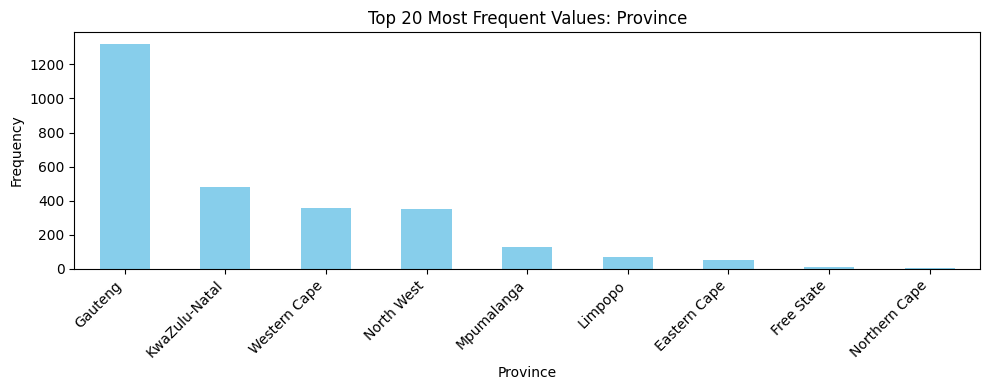

✅ Saved: outputs/task4/Province_barplot.png


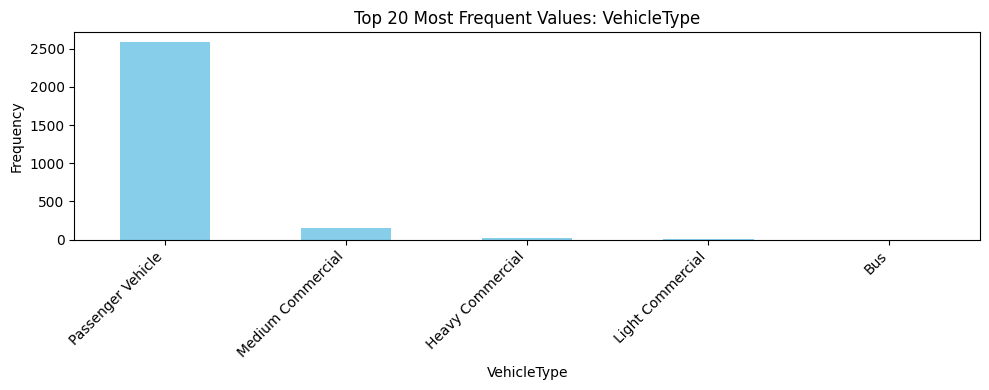

✅ Saved: outputs/task4/VehicleType_barplot.png


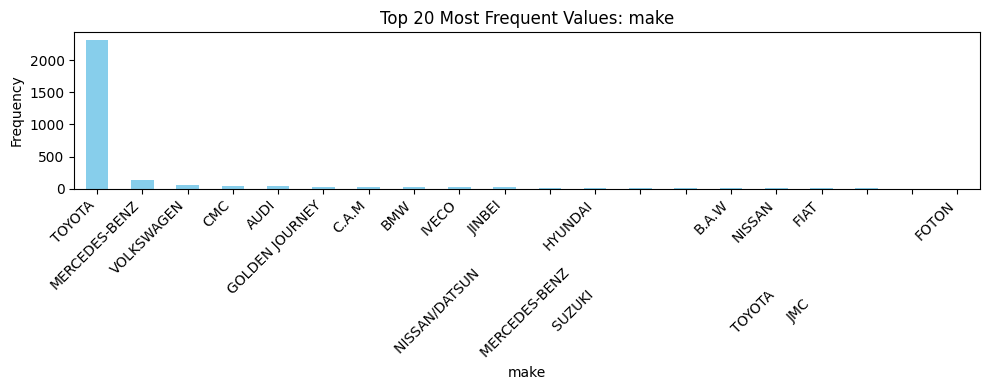

✅ Saved: outputs/task4/make_barplot.png

🔧 Training Linear Regression...


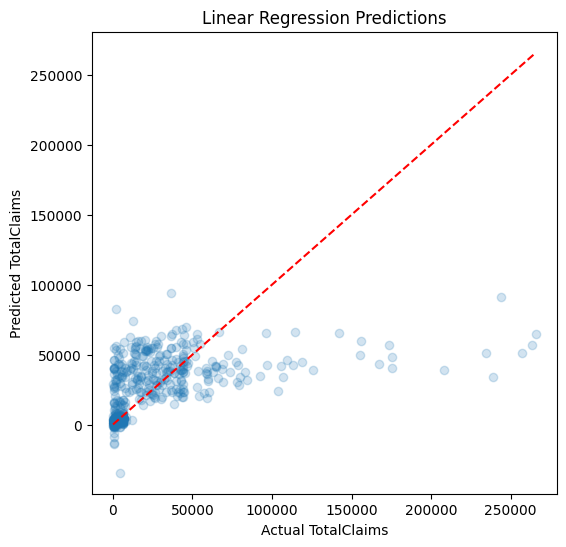

✅ Model saved: outputs/task4/linear_regression_model.joblib
✅ Plot saved: outputs/task4/linear_regression_predictions.png

🔧 Training Random Forest...


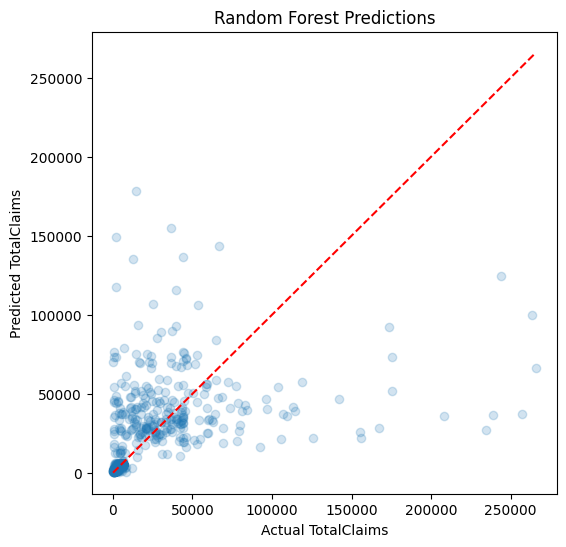

✅ Model saved: outputs/task4/random_forest_model.joblib
✅ Plot saved: outputs/task4/random_forest_predictions.png

🔧 Training Gradient Boosting...


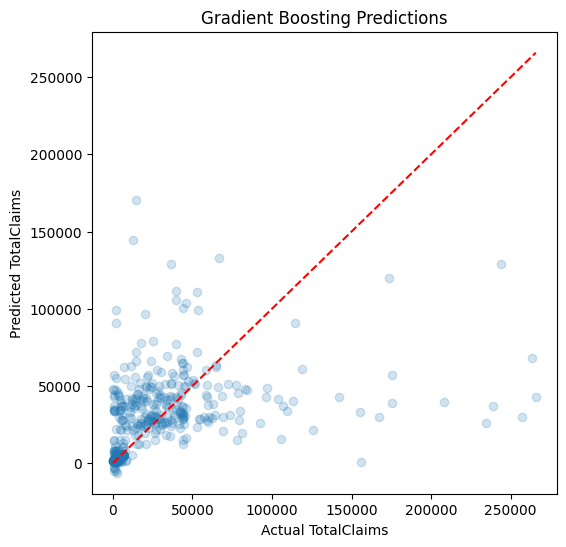

✅ Model saved: outputs/task4/gradient_boosting_model.joblib
✅ Plot saved: outputs/task4/gradient_boosting_predictions.png

📈 Evaluation Results:
Linear Regression: RMSE = 32096.46, R² = 0.2766
Random Forest: RMSE = 35531.10, R² = 0.1135
Gradient Boosting: RMSE = 34647.22, R² = 0.1571


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Load the data
df = pd.read_csv("../data/MachineLearningRating_v3.txt", delimiter="|", low_memory=False)

# Create output directory
os.makedirs("outputs/task4", exist_ok=True)

# Step 1: Feature Engineering
df["ClaimOccurred"] = (df["TotalClaims"] > 0).astype(int)
df["Margin"] = df["TotalPremium"] - df["TotalClaims"]

# Step 2: Filter only rows with claims
severity_df = df[df["TotalClaims"] > 0].copy()

# Step 3: Select features and target
features = ["Province", "VehicleType", "RegistrationYear", "make", "SumInsured", "CalculatedPremiumPerTerm"]
severity_df = severity_df.dropna(subset=features + ["TotalClaims"])
X = severity_df[features]
y = severity_df["TotalClaims"]

# Step 4: Save and print summaries
summary_lines = []
summary_lines.append("✅ Preprocessing Summary for TotalClaims Severity Model")
summary_lines.append("=" * 60)
summary_lines.append(f"Total rows after filtering: {len(severity_df)}")
summary_lines.append(f"Selected features: {features}\n")

for col in features:
    summary_lines.append(f"▶ Feature: {col}")
    if X[col].dtype == "object":
        summary_lines.append(str(X[col].value_counts().head(5)) + "\n")
    else:
        summary_lines.append(str(X[col].describe()) + "\n")

with open("outputs/task4/preprocessing_summary.txt", "w") as f:
    f.write("\n".join(summary_lines))
print("\n".join(summary_lines))

# Step 5: Visualize categorical features
categorical_cols = X.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    plt.figure(figsize=(10, 4))
    X[col].value_counts().sort_values(ascending=False).head(20).plot(kind='bar', color='skyblue')
    plt.title(f"Top 20 Most Frequent Values: {col}")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plot_path = f"outputs/task4/{col}_barplot.png"
    plt.savefig(plot_path)
    plt.show()
    print(f"✅ Saved: {plot_path}")

# Step 6: Encode categorical features
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_cat = encoder.fit_transform(X[categorical_cols])
X_num = X.select_dtypes(exclude=["object"]).values
X_encoded = np.hstack((X_cat, X_num))

# Step 7: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Step 8: Train models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": HistGradientBoostingRegressor(max_iter=100, random_state=42)
}

evaluation_results = []

for name, model in models.items():
    print(f"\n🔧 Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluation
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    evaluation_results.append((name, rmse, r2))

    # Save model
    model_path = f"outputs/task4/{name.replace(' ', '_').lower()}_model.joblib"
    joblib.dump(model, model_path)

    # Plot prediction vs actual
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.2)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
    plt.xlabel("Actual TotalClaims")
    plt.ylabel("Predicted TotalClaims")
    plt.title(f"{name} Predictions")
    plot_path = f"outputs/task4/{name.replace(' ', '_').lower()}_predictions.png"
    plt.savefig(plot_path)
    plt.show()
    print(f"✅ Model saved: {model_path}")
    print(f"✅ Plot saved: {plot_path}")

# Step 9: Save evaluation summary
eval_path = "outputs/task4/model_evaluation.txt"
with open(eval_path, "w") as f:
    f.write("📊 Model Evaluation Summary\n")
    f.write("=" * 40 + "\n")
    for name, rmse, r2 in evaluation_results:
        f.write(f"{name}\n")
        f.write(f" - RMSE: {rmse:.2f}\n")
        f.write(f" - R²: {r2:.4f}\n")
        f.write("-" * 40 + "\n")

# Display summary in notebook
print("\n📈 Evaluation Results:")
for name, rmse, r2 in evaluation_results:
    print(f"{name}: RMSE = {rmse:.2f}, R² = {r2:.4f}")
